In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras
!pip install tensorflo

ERROR: Could not find a version that satisfies the requirement tensorflo (from versions: none)
ERROR: No matching distribution found for tensorflo


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import History

from keras.preprocessing.text import Tokenizer
from keras import layers
from keras.layers import Embedding
from keras.layers import Reshape, Flatten
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D
from keras.layers import AveragePooling1D, Input, Dropout, concatenate

from wordcloud import WordCloud, STOPWORDS

import pickle

In [4]:
# Maximum number of words to be embedded
testbench_fni = pd.read_excel('/content/drive/MyDrive/Datasets_BTP/FNI/fakenewsincidents_india_dataset_v1.xls')
testbench_fni['label'] = 0
testbench_fni = testbench_fni[['Content', 'label']]
testbench_fni.columns = ['text', 'label']
testbench_fni.text=testbench_fni.text.astype(str)
print(testbench_fni.shape)
# testbench_fni = testbench_fni.sample(200)

testbench_ind = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/IND/IND_poli.csv')
testbench_ind['label'] = 1
# testbench_ind.columns
testbench_ind = testbench_ind[['News Abstract','label']]
testbench_ind.columns = ['text', 'label']
print(testbench_ind.shape)

t1 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/12-02-2024-Articles.csv')
t2 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/13-02-2024-Articles.csv')
t3 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/14-02-2024-Articles.csv')
t4 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/16-02-2024-Articles.csv')
t5 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/20-02-2024-Articles.csv')
t6 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/9-02-2024-Articles.csv')
t7 = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/TOI_Scrapped/24-02-2024-Articles.csv')

testbench_toi = pd.concat([t1,t2,t3,t4,t5,t6,t7])
testbench_toi['label'] = 1
testbench_toi = testbench_toi[['text', 'label']]
print(testbench_toi.columns)
print(testbench_toi.shape)
testbench_gs = pd.concat([testbench_toi, testbench_ind, testbench_fni])
print(testbench_gs.shape)

(4802, 2)
(200, 2)
Index(['text', 'label'], dtype='object')
(584, 2)
(5586, 2)


In [5]:
sample_gn = 200
testbench_isot_fake = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/Fake.csv', delimiter=',')
testbench_isot_real = pd.read_csv('/content/drive/MyDrive/Datasets_BTP/ISOT/True.csv', delimiter = ',')
# testbench_isot_fake.head
testbench_isot_fake['label'] = 0
testbench_isot_real['label'] = 1
testbench_isot = pd.concat([testbench_isot_fake,testbench_isot_real])
testbench_isot_real.shape

(21417, 5)

##Global North Model

###GN Data

In [7]:
modelA = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelA_saved_GN.pkl', 'rb'))
modelB = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelB_saved_GN.pkl', 'rb'))
modelC = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelC_saved_GN.pkl', 'rb'))

prStatsA = []
f1StatsA = []
reStatsA = []

prStatsB = []
f1StatsB = []
reStatsB = []

prStatsC = []
f1StatsC = []
reStatsC = []

x = []

NUM_WORDS = 30000
EMBEDDING_DIM=100
MAX_SEQUENCE_LENGTH = 1000

for i in range(500, 20000, 500):
  x.append(i)
  tsample0 = testbench_isot_fake.sample(i, random_state=42)
  tsample1 = testbench_isot_real.sample(i, random_state=42)
  testbench_isot = pd.concat([tsample0,tsample1])

  tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
  tokenizer.fit_on_texts(testbench_isot['text'])
  sequences = tokenizer.texts_to_sequences(testbench_isot['text'])
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

  loss, pr, re = modelA.evaluate(data, testbench_isot[['label']])
  prStatsA.append(pr)
  f1StatsA.append((2*pr*re)/(pr+re))
  reStatsA.append(re)

  loss, pr, re = modelB.evaluate(data, testbench_isot[['label']])
  prStatsB.append(pr)
  f1StatsB.append((2*pr*re)/(pr+re))
  reStatsB.append(re)

  loss, pr, re = modelC.evaluate(data, testbench_isot[['label']])
  prStatsC.append(pr)
  f1StatsC.append((2*pr*re)/(pr+re))
  reStatsC.append(re)

1219/1219 [==============================] - 15s 12ms/step - loss: 2.2802 - precision_2: 0.7758 - recall_2: 0.4391


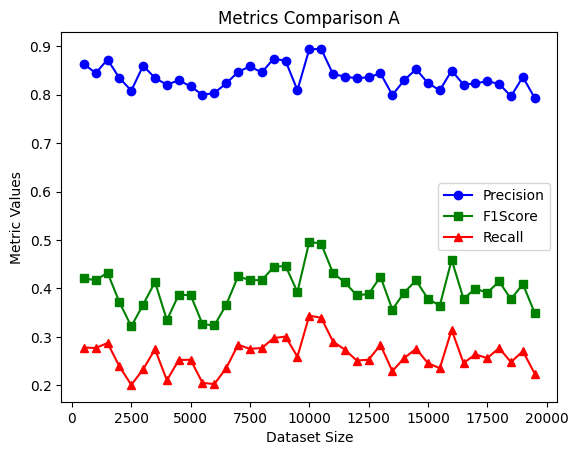

In [8]:
plt.plot(x, prStatsA, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsA, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsA, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison A')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

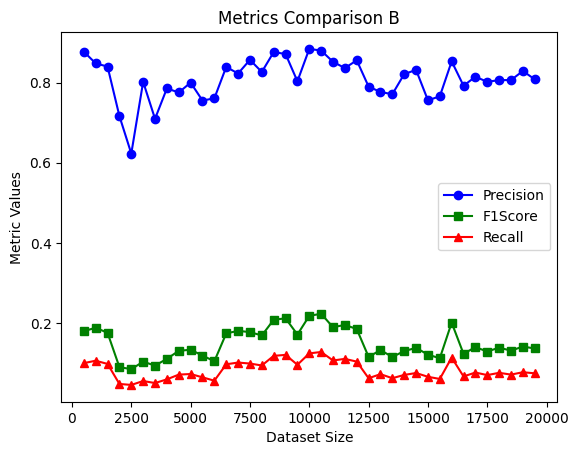

In [9]:
plt.plot(x, prStatsB, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsB, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsB, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison B')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

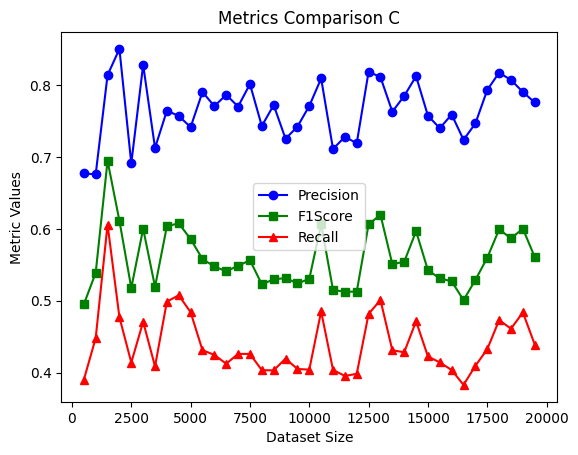

In [10]:
plt.plot(x, prStatsC, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsC, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsC, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison C')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

###GS Data

In [11]:
modelA = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelA_saved_GN.pkl', 'rb'))
modelB = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelB_saved_GN.pkl', 'rb'))
modelC = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelC_saved_GN.pkl', 'rb'))

prStatsA = []
f1StatsA = []
reStatsA = []

prStatsB = []
f1StatsB = []
reStatsB = []

prStatsC = []
f1StatsC = []
reStatsC = []

x = []

NUM_WORDS = 30000
EMBEDDING_DIM=100
MAX_SEQUENCE_LENGTH = 1000

for i in range(100, 5503, 200):
  x.append(i)
  # tsample0 = testbench_fni.sample(i, random_state=42)
  # tsample1 = testbench_ind.sample(i, random_state=42)
  # testbench_isot = pd.concat([tsample0,tsample1])
  testbench_curr = testbench_gs.sample(i, random_state=42)

  tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
  tokenizer.fit_on_texts(testbench_curr['text'])
  sequences = tokenizer.texts_to_sequences(testbench_curr['text'])
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

  loss, pr, re = modelA.evaluate(data, testbench_curr[['label']])
  prStatsA.append(pr)
  f1StatsA.append((2*pr*re)/(pr+re))
  reStatsA.append(re)

  loss, pr, re = modelB.evaluate(data, testbench_curr[['label']])
  prStatsB.append(pr)
  if (pr+re) > 0:
    f1StatsB.append((2*pr*re)/(pr+re))
  else:
    f1StatsB.append(0)
  reStatsB.append(re)

  loss, pr, re = modelC.evaluate(data, testbench_curr[['label']])
  prStatsC.append(pr)
  f1StatsC.append((2*pr*re)/(pr+re))
  reStatsC.append(re)

172/172 [==============================] - 2s 12ms/step - loss: 2.0610 - precision_2: 0.0868 - recall_2: 0.1373


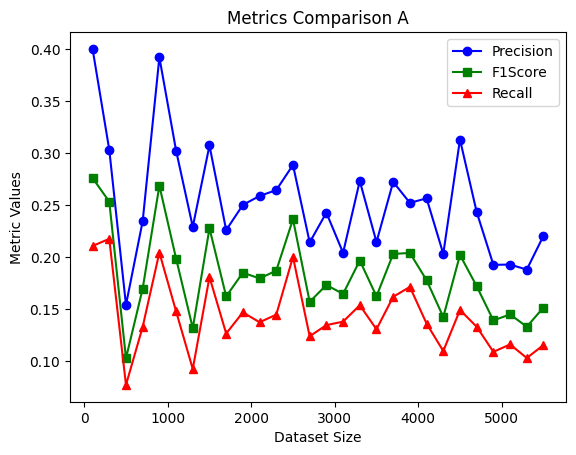

In [12]:
plt.plot(x, prStatsA, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsA, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsA, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison A')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

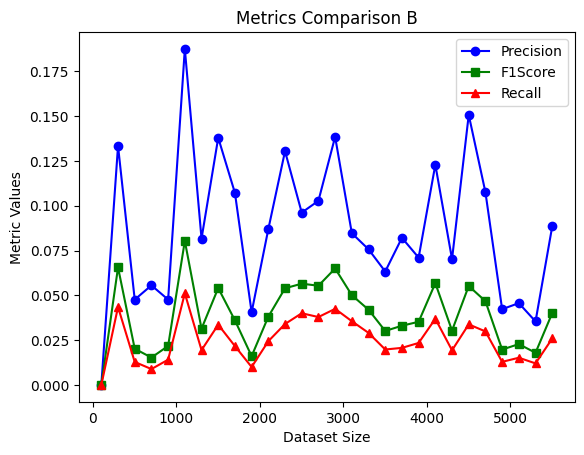

In [13]:
plt.plot(x, prStatsB, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsB, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsB, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison B')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

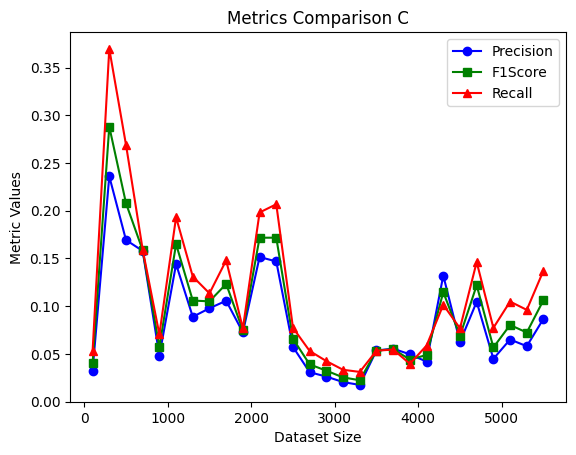

In [14]:
plt.plot(x, prStatsC, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsC, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsC, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison C')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

##Equal Model

###GN Data

In [15]:
modelA = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelA_saved_eq.pkl', 'rb'))
modelB = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelB_saved_eq.pkl', 'rb'))
modelC = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelC_saved_eq.pkl', 'rb'))

prStatsA = []
f1StatsA = []
reStatsA = []

prStatsB = []
f1StatsB = []
reStatsB = []

prStatsC = []
f1StatsC = []
reStatsC = []

x = []

NUM_WORDS = 30000
EMBEDDING_DIM=100
MAX_SEQUENCE_LENGTH = 1000

for i in range(500, 20000, 500):
  x.append(i)
  tsample0 = testbench_isot_fake.sample(i, random_state=42)
  tsample1 = testbench_isot_real.sample(i, random_state=42)
  testbench_isot = pd.concat([tsample0,tsample1])

  tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
  tokenizer.fit_on_texts(testbench_isot['text'])
  sequences = tokenizer.texts_to_sequences(testbench_isot['text'])
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

  loss, acc, pr, re = modelA.evaluate(data, testbench_isot[['label']])
  prStatsA.append(pr)
  f1StatsA.append((2*pr*re)/(pr+re))
  reStatsA.append(re)

  loss, acc, pr, re = modelB.evaluate(data, testbench_isot[['label']])
  prStatsB.append(pr)
  f1StatsB.append((2*pr*re)/(pr+re))
  reStatsB.append(re)

  loss, acc, pr, re = modelC.evaluate(data, testbench_isot[['label']])
  prStatsC.append(pr)
  f1StatsC.append((2*pr*re)/(pr+re))
  reStatsC.append(re)

1219/1219 [==============================] - 14s 12ms/step - loss: 1.9002 - acc: 0.5267 - precision_2: 0.5280 - recall_2: 0.5035


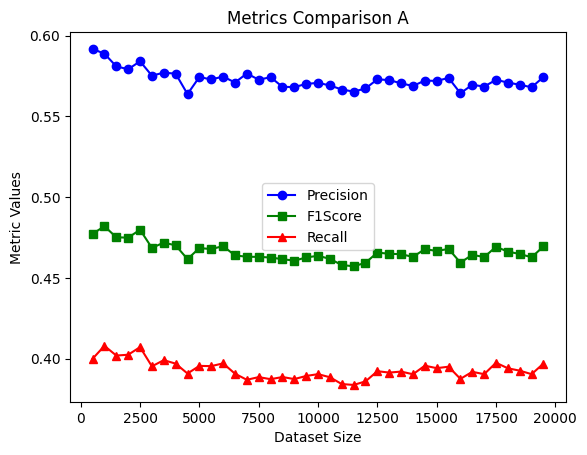

In [16]:
plt.plot(x, prStatsA, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsA, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsA, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison A')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

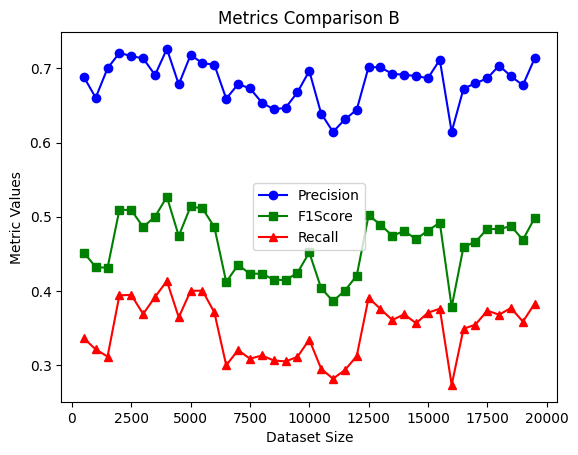

In [17]:
plt.plot(x, prStatsB, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsB, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsB, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison B')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

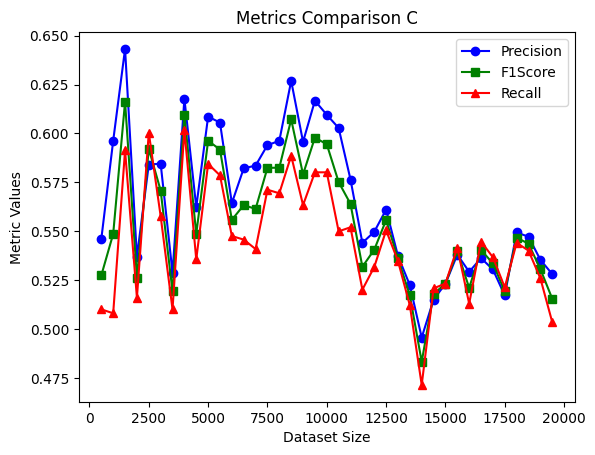

In [18]:
plt.plot(x, prStatsC, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsC, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsC, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison C')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

###GS Data

In [19]:
modelA = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelA_saved_eq.pkl', 'rb'))
modelB = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelB_saved_eq.pkl', 'rb'))
modelC = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelC_saved_eq.pkl', 'rb'))

prStatsA = []
f1StatsA = []
reStatsA = []

prStatsB = []
f1StatsB = []
reStatsB = []

prStatsC = []
f1StatsC = []
reStatsC = []

x = []

NUM_WORDS = 30000
EMBEDDING_DIM=100
MAX_SEQUENCE_LENGTH = 1000

for i in range(100, 5503, 200):
  x.append(i)
  # tsample0 = testbench_fni.sample(i, random_state=42)
  # tsample1 = testbench_ind.sample(i, random_state=42)
  # testbench_isot = pd.concat([tsample0,tsample1])
  testbench_curr = testbench_gs.sample(i, random_state=42)

  tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
  tokenizer.fit_on_texts(testbench_curr['text'])
  sequences = tokenizer.texts_to_sequences(testbench_curr['text'])
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

  loss, acc, pr, re = modelA.evaluate(data, testbench_curr[['label']])
  prStatsA.append(pr)
  f1StatsA.append((2*pr*re)/(pr+re))
  reStatsA.append(re)

  loss, acc, pr, re = modelB.evaluate(data, testbench_curr[['label']])
  prStatsB.append(pr)
  f1StatsB.append((2*pr*re)/(pr+re))
  reStatsB.append(re)

  loss, acc, pr, re = modelC.evaluate(data, testbench_curr[['label']])
  prStatsC.append(pr)
  f1StatsC.append((2*pr*re)/(pr+re))
  reStatsC.append(re)

172/172 [==============================] - 2s 12ms/step - loss: 1.4815 - acc: 0.6171 - precision_2: 0.2017 - recall_2: 0.5842


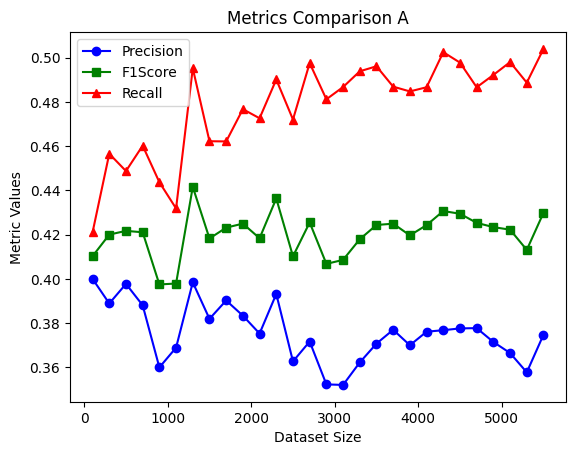

In [20]:
plt.plot(x, prStatsA, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsA, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsA, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison A')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

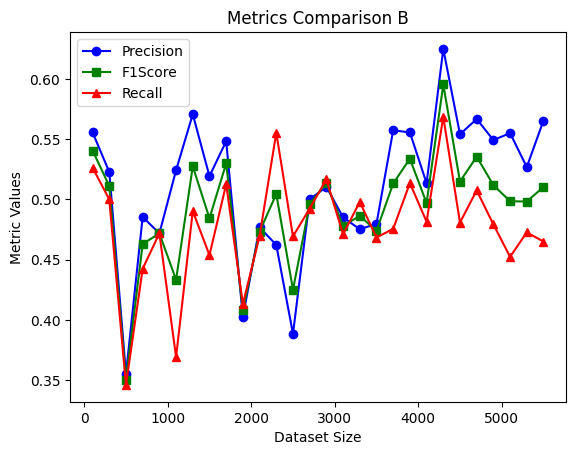

In [21]:
plt.plot(x, prStatsB, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsB, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsB, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison B')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

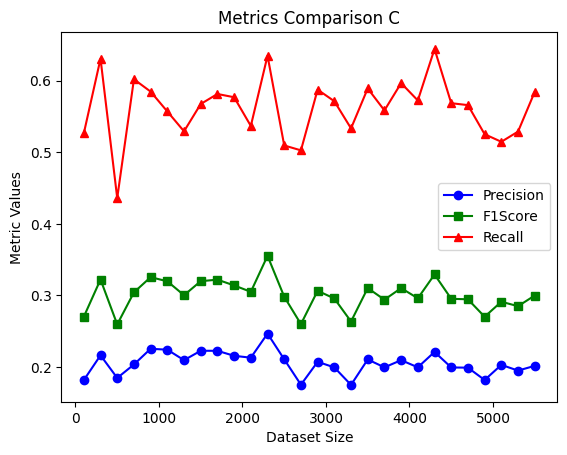

In [22]:
plt.plot(x, prStatsC, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsC, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsC, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison C')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

##Global South Model

###GN Data

In [23]:
modelA = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelA_saved_GS.pkl', 'rb'))
modelB = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelB_saved_GS.pkl', 'rb'))
modelC = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelC_saved_GS.pkl', 'rb'))

prStatsA = []
f1StatsA = []
reStatsA = []

prStatsB = []
f1StatsB = []
reStatsB = []

prStatsC = []
f1StatsC = []
reStatsC = []

x = []

NUM_WORDS = 30000
EMBEDDING_DIM=100
MAX_SEQUENCE_LENGTH = 1000

for i in range(500, 20000, 500):
  x.append(i)
  tsample0 = testbench_isot_fake.sample(i, random_state=42)
  tsample1 = testbench_isot_real.sample(i, random_state=42)
  testbench_isot = pd.concat([tsample0,tsample1])

  tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
  tokenizer.fit_on_texts(testbench_isot['text'])
  sequences = tokenizer.texts_to_sequences(testbench_isot['text'])
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

  loss, pr, re = modelA.evaluate(data, testbench_isot[['label']])
  prStatsA.append(pr)
  f1StatsA.append((2*pr*re)/(pr+re))
  reStatsA.append(re)

  loss, pr, re = modelB.evaluate(data, testbench_isot[['label']])
  prStatsB.append(pr)
  f1StatsB.append((2*pr*re)/(pr+re))
  reStatsB.append(re)

  loss, pr, re = modelC.evaluate(data, testbench_isot[['label']])
  prStatsC.append(pr)
  f1StatsC.append((2*pr*re)/(pr+re))
  reStatsC.append(re)

1219/1219 [==============================] - 15s 12ms/step - loss: 1.5081 - precision_2: 0.5394 - recall_2: 0.6385


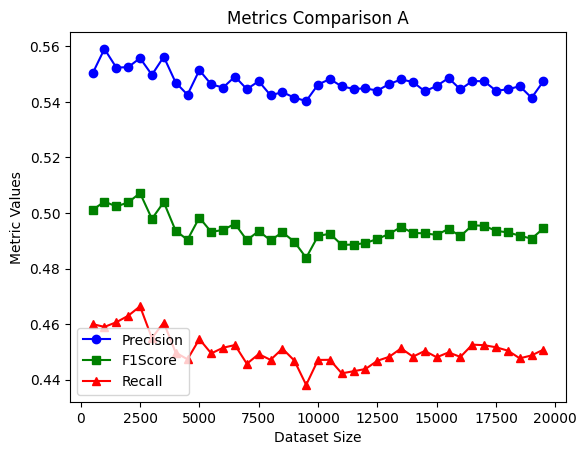

In [24]:
plt.plot(x, prStatsA, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsA, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsA, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison A')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

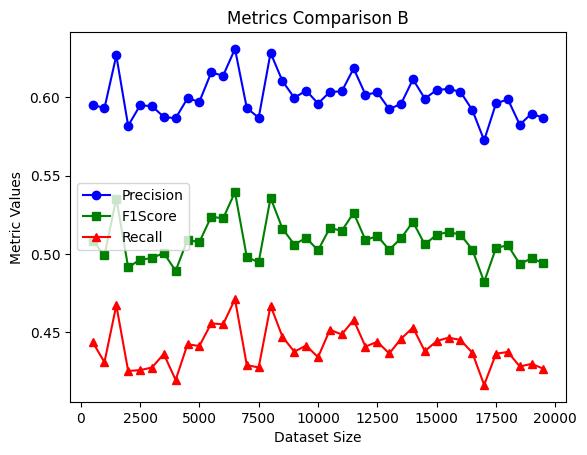

In [25]:
plt.plot(x, prStatsB, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsB, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsB, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison B')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

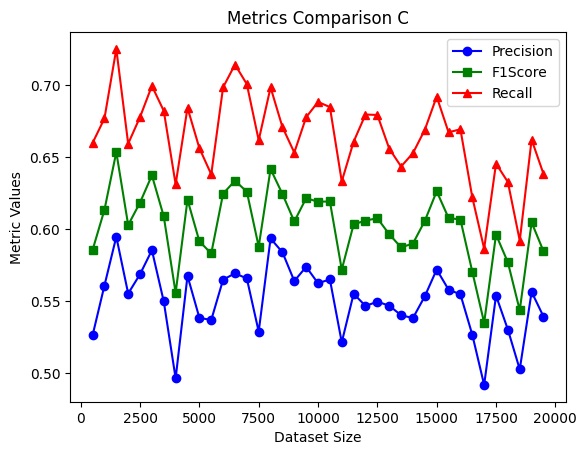

In [26]:
plt.plot(x, prStatsC, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsC, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsC, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison C')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

###GS Data

In [27]:
modelA = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelA_saved_GS.pkl', 'rb'))
modelB = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelB_saved_GS.pkl', 'rb'))
modelC = pickle.load(open('/content/drive/MyDrive/Datasets_BTP/Models/modelC_saved_GS.pkl', 'rb'))

prStatsA = []
f1StatsA = []
reStatsA = []

prStatsB = []
f1StatsB = []
reStatsB = []

prStatsC = []
f1StatsC = []
reStatsC = []

x = []

NUM_WORDS = 30000
EMBEDDING_DIM=100
MAX_SEQUENCE_LENGTH = 1000

for i in range(100, 5503, 200):
  x.append(i)
  # tsample0 = testbench_fni.sample(i, random_state=42)
  # tsample1 = testbench_ind.sample(i, random_state=42)
  # testbench_isot = pd.concat([tsample0,tsample1])
  testbench_curr = testbench_gs.sample(i, random_state=42)

  tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
  tokenizer.fit_on_texts(testbench_curr['text'])
  sequences = tokenizer.texts_to_sequences(testbench_curr['text'])
  data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')

  loss, pr, re = modelA.evaluate(data, testbench_curr[['label']])
  prStatsA.append(pr)
  f1StatsA.append((2*pr*re)/(pr+re))
  reStatsA.append(re)

  loss, pr, re = modelB.evaluate(data, testbench_curr[['label']])
  prStatsB.append(pr)
  f1StatsB.append((2*pr*re)/(pr+re))
  reStatsB.append(re)

  loss, pr, re = modelC.evaluate(data, testbench_curr[['label']])
  prStatsC.append(pr)
  f1StatsC.append((2*pr*re)/(pr+re))
  reStatsC.append(re)

172/172 [==============================] - 2s 12ms/step - loss: 1.5616 - precision_2: 0.1869 - recall_2: 0.7448


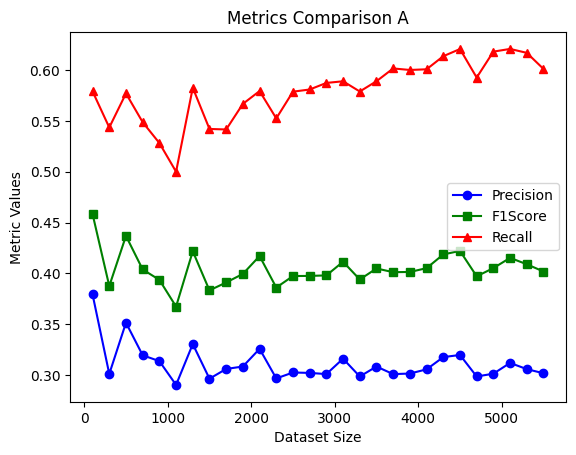

In [28]:
plt.plot(x, prStatsA, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsA, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsA, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison A')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

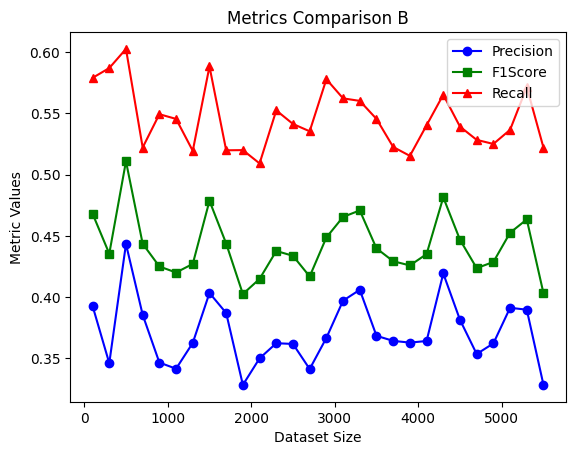

In [29]:
plt.plot(x, prStatsB, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsB, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsB, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison B')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()

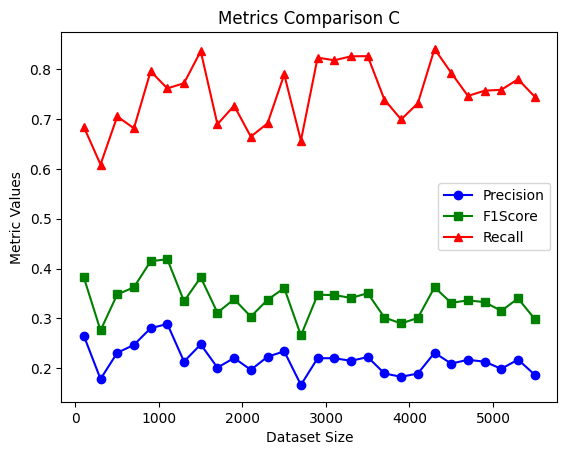

In [30]:
plt.plot(x, prStatsC, label='Precision', color='blue', marker='o')
plt.plot(x, f1StatsC, label='F1Score', color='green', marker='s')
plt.plot(x, reStatsC, label='Recall', color='red', marker='^')

# Adding labels and title
plt.xlabel('Dataset Size')
plt.ylabel('Metric Values')
plt.title('Metrics Comparison C')

# Adding legend
plt.legend()

# Displaying the graph
plt.show()